In [127]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd

dataDir = Path('../dataset/images') 
annotationsDir = Path('../dataset/annotations')

img = cv2.imread(os.path.join(dataDir, 'road58.png'))

In [128]:
# Classification setup

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(dataDir) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [129]:
df_train = generate_train_df(annotationsDir)
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,../dataset/images/road712.png,300,400,speedlimit,98,140,139,182
1,../dataset/images/road706.png,300,400,speedlimit,136,92,177,135
2,../dataset/images/road289.png,300,400,stop,61,140,146,227
3,../dataset/images/road538.png,300,400,speedlimit,115,169,149,205
4,../dataset/images/road510.png,300,400,speedlimit,89,201,133,245


In [130]:
# Image Pre-processing

# Improve Lighting

def improve_lighting(img):
    imgYUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    imgYUV[:, :, 0] = cv2.equalizeHist(imgYUV[:, :, 0])

    imgBetterLighting = cv2.cvtColor(imgYUV, cv2.COLOR_YUV2BGR)

    imgHSV = cv2.cvtColor(imgBetterLighting, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(imgHSV)

    lim = 255 - 50
    v[v > lim] = 255
    v[v <= lim] += 50

    final_hsv = cv2.merge((h, s, v))
    imgBetterLighting = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    return imgBetterLighting

# Smooth

def image_smooth(img):
    imgWithMedianFilter = cv2.medianBlur(img, 5)

    return imgWithMedianFilter


In [131]:
# Image Segmentation

def image_segmentation(img):
    #set the bounds for the red hue
    lower_red_n1 = np.array([0,70,60])
    upper_red_n1 = np.array([10,255,255])

    lower_red_n2 = np.array([170,70,60])
    upper_red_n2 = np.array([180,255,255])

    lower_blue_n3 = np.array([78,158,124])
    upper_blue_n3 = np.array([138,255,255])

    #create a mask using the bounds set

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


    mask_1 = cv2.inRange(img_hsv, lower_red_n1, upper_red_n1)
    mask_2 = cv2.inRange(img_hsv, lower_red_n2, upper_red_n2)

    mask_red = mask_1 + mask_2

    mask_blue = cv2.inRange(img_hsv, lower_blue_n3, upper_blue_n3)

    return mask_blue, mask_red

In [132]:
# Image Thresholding and Morphological Operations

def morphological_ops(img):
    # Red

    # Removing Noise
    kernel = np.ones((3, 3),np.uint8)
    processed_red = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations = 1)
    processed_red = cv2.morphologyEx(processed_red, cv2.MORPH_DILATE, kernel, iterations = 1)

    # Floodfill

    red_floodfill = processed_red.copy()

    h, w = processed_red.shape[:2]

    mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(red_floodfill, mask, (0,0), 255)

    red_floodfill_inv = cv2.bitwise_not(red_floodfill)

    filled_image = processed_red | red_floodfill_inv

    return filled_image

In [133]:
# Shape Recognition

def shape_recognition(img_red, img_blue):
    result = ""

    # Red
    debug = "red"

    # Octagon Detection
    contours_red, hierarchy_red = cv2.findContours(img_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours_red:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        #print(len(approx))

        if len(approx) == 8:
            print('Found STOP sign')
            result = "stop"
            img_red_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)

        elif len(approx) >= 12:
            print('Found red circle sign')
            result = "speedlimit"
            img_red_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)

    # Blue

    contours_blue, hierarchy_blue = cv2.findContours(img_blue, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours_blue:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        #print(len(approx))

        if len(approx) == 4:
            print('Found BLUE sign')
            result = "crosswalk"
            debug = "blue"
            img_blue_contours = cv2.drawContours(img, [cnt], 0, (255,0,0), -1)


    if debug=="red":
        plt.imshow(cv2.cvtColor(img_red_contours, cv2.COLOR_BGR2RGB))
        plt.title('Foreground')
        plt.axis('off')
        plt.show()
    elif debug == "blue":
        plt.imshow(cv2.cvtColor(img_blue_contours, cv2.COLOR_BGR2RGB))
        plt.title('Foreground')
        plt.axis('off')
        plt.show()
    
    return result


Found STOP sign


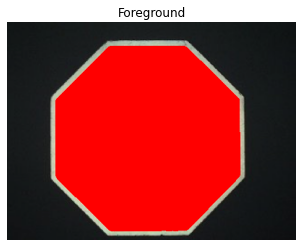

'stop'

In [134]:
def evaluate_image(img):
    
    imgLighting = improve_lighting(img)
    imgSmooth = image_smooth(imgLighting)
    img_blue, img_red = image_segmentation(imgSmooth)
    processed_blue = morphological_ops(img_blue)
    processed_red = morphological_ops(img_red)
    result = shape_recognition(processed_red, processed_blue)
    
    return result

evaluate_image(img)

In [136]:
# Classification train
cnt = 1

print(df_train.shape)

for index, row in df_train.iterrows():
    if row['class'] == 'trafficlight':
        break
    else:
        print(row['filename'])

(877, 8)
../dataset/images/road712.png
../dataset/images/road706.png
../dataset/images/road289.png
../dataset/images/road538.png
../dataset/images/road510.png
../dataset/images/road276.png
../dataset/images/road262.png
../dataset/images/road504.png
../dataset/images/road458.png
../dataset/images/road464.png
../dataset/images/road302.png
../dataset/images/road316.png
../dataset/images/road470.png
../dataset/images/road841.png
../dataset/images/road699.png
../dataset/images/road855.png
../dataset/images/road869.png
